# Evaluate likelihood ratio and posterior

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

from units import *
from simulation import SubhaloSimulator
from inference.inference import Estimator

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Prior

In [2]:
alpha_mean = 1000.
alpha_std = alpha_mean * 0.2
beta_mean = -1.9
beta_std = 0.2

## Test data

In [3]:
n_observations = 100

In [4]:
mass_base_unit = 1.e7 * M_s

alpha_true = alpha_mean
beta_true = beta_mean

alpha_true, beta_true

(1000.0, -1.9)

In [5]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=100.,
)

img = sim.rvs(alpha_true, beta_true, n_observations)

16:41 simulation           INFO    Simulating image 5 / 100
16:41 simulation           INFO    Simulating image 10 / 100
16:41 simulation           INFO    Simulating image 15 / 100
16:41 simulation           INFO    Simulating image 20 / 100
16:41 simulation           INFO    Simulating image 25 / 100
16:41 simulation           INFO    Simulating image 30 / 100
16:41 simulation           INFO    Simulating image 35 / 100
16:41 simulation           INFO    Simulating image 40 / 100
16:41 simulation           INFO    Simulating image 45 / 100
16:41 simulation           INFO    Simulating image 50 / 100
16:41 simulation           INFO    Simulating image 55 / 100
16:41 simulation           INFO    Simulating image 60 / 100
16:41 simulation           INFO    Simulating image 65 / 100
16:41 simulation           INFO    Simulating image 70 / 100
16:41 simulation           INFO    Simulating image 75 / 100
16:41 simulation           INFO    Simulating image 80 / 100
16:41 simulation         

## Prepare evaluation

In [6]:
grid_res = 11

alpha_test = np.linspace(500., 1500., grid_res)
beta_test = np.linspace(-1.5, -2.3, grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [7]:
re = Estimator()
re.load("../models/carl")

## Likelihood ratio

In [8]:
log_r, _ = re.evaluate_ratio(x=img, theta0=theta_grid)
nllr = -2. * np.sum(log_r, axis=1).reshape(grid_res, grid_res)

In [9]:
best_fit = theta_grid[np.argmin(nllr.flatten())]

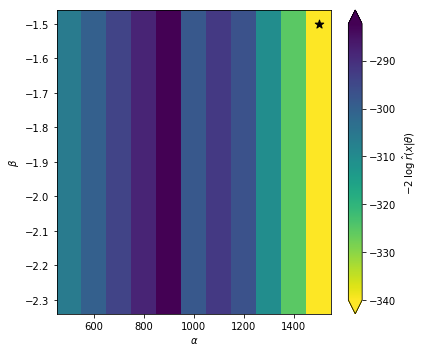

In [10]:
cmin, cmax = np.min(nllr), np.max(nllr)

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()
    
pcm = ax.pcolormesh(
    alpha_edges,
    beta_edges,
    nllr,
    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
    cmap='viridis_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$')

plt.tight_layout()
plt.show()

## Evaluate posterior

In [11]:
prior_grid = []
for alpha, beta in theta_grid:
    prior = norm.pdf(
        alpha, loc=alpha_mean, scale=alpha_std
    ) * norm.pdf(
        beta, loc=beta_mean, scale=beta_std
    )
    
    prior_grid.append(prior)
    
prior_grid = np.array(prior_grid)

In [12]:
n_prior_samples = 100

alpha_from_prior = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_prior_samples)
beta_from_prior = np.random.normal(loc=beta_mean, scale=beta_std, size=n_prior_samples)
thetas_from_prior = np.vstack((alpha_from_prior, beta_from_prior)).T

In [13]:
posterior = re.evaluate_posterior(
    xs=img,
    thetas_eval=theta_grid,
    prior_thetas_eval=prior_grid,
    thetas_from_prior=thetas_from_prior
)

In [14]:
best_fit = theta_grid[np.argmax(posterior.flatten())]

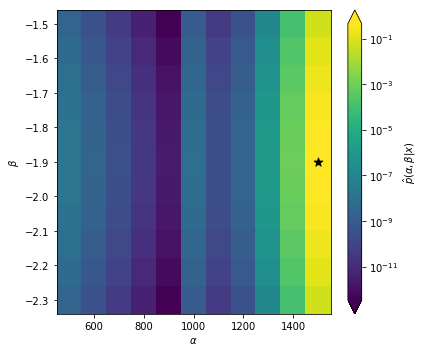

In [18]:
cmin, cmax = np.min(posterior), np.max(posterior)

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()
    
pcm = ax.pcolormesh(
    alpha_edges,
    beta_edges,
    posterior.reshape(grid_res, grid_res),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='viridis'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
cbar.set_label(r'$\hat{p}(\alpha, \beta | x)$')

plt.tight_layout()
plt.show()